# Analisando o bot

Este jupyter-notebook vai auxiliar na análise de detecção de intenções da Taís.

## Instalação

### Configurando jupyter

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Listando versões

In [2]:
import rasa_nlu

print("rasa_nlu: {}".format(rasa_nlu.__version__))

rasa_nlu: 0.13.7


### Treinando o modelo do Rasa NLU

Na celula abaixo todas as intents na pasta `../data/intents/` serão utilizadas para gerar a matrix de confuzão para de avaliação do bot.

Ela irá treinar o modelo e executar a avaliação que pode ser verificada na saída da célula abaixo.

In [3]:
import os

from rasa_nlu.training_data import load_data
from rasa_nlu.model import Trainer
from rasa_nlu import config


intents_directory = '../../bot/data/intents/'

intents = {}

for intent_file in os.listdir(intents_directory):
    intent_file_path = os.path.join(intents_directory, intent_file)

    intents[intent_file] = {}

    intent_list = []
    intent_name = None

    with open(intent_file_path) as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip()

            if line.startswith('##'):
                if intent_name is not None:
                    intents[intent_file][intent_name] = intent_list
                intent_name = line.replace('## intent:', '') 
                intent_list = []

            elif line.startswith('- '):
                intent_list.append(line.replace('- ', ''))


# loading the nlu training samples
training_data = load_data(intents_directory)

# trainer to educate our pipeline
trainer = Trainer(config.load("../../bot/nlu_config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/random.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 204 (25 distinct intents)
	- Found intents: 'me', 'team', 'where_u_liv', 'religion', 'towel', 'story', 'languages', 'hobby', 'sad', 'star_wars', 'relationship', 'sport', 'joke', 'color', 'genre', 'license', 'sons', 'sign', 'food', 'playlist', 'where_r_u_from', 'bff', 'laugh', 'movie', 'how_am_i'
	- entity examples: 177 (23 distinct entities)
	- found entities: 'me', 'religion', 'starwars', 'towel', 'story', 'hobby', 'how', 'languages', 'sport', 'joke', 'genre', 'food', 'playlist', 'bff', 'where', 'movie', 'sad', 'relationship', 'color', 'license', 'sons', 'sign', 'live'

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/general.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 85 (7 distinct intents)
	- Found intents: 'elogios', 'd

INFO:tensorflow:Restoring parameters from /work/notebooks/intents/./models/nlu/default/current/intent_classifier_tensorflow_embedding.ckpt
INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/random.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 204 (25 distinct intents)
	- Found intents: 'me', 'team', 'where_u_liv', 'religion', 'towel', 'story', 'languages', 'hobby', 'sad', 'star_wars', 'relationship', 'sport', 'joke', 'color', 'genre', 'license', 'sons', 'sign', 'food', 'playlist', 'where_r_u_from', 'bff', 'laugh', 'movie', 'how_am_i'
	- entity examples: 177 (23 distinct entities)
	- found entities: 'me', 'religion', 'starwars', 'towel', 'story', 'hobby', 'how', 'languages', 'sport', 'joke', 'genre', 'food', 'playlist', 'bff', 'where', 'movie', 'sad', 'relationship', 'color', 'license', 'sons', 'sign', 'live'

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/general.md is md


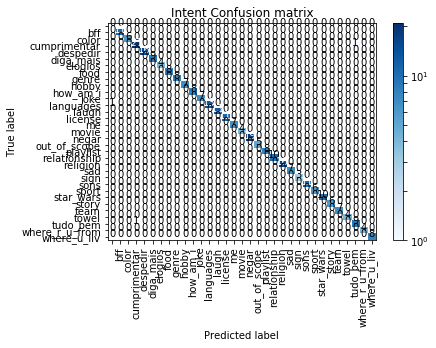

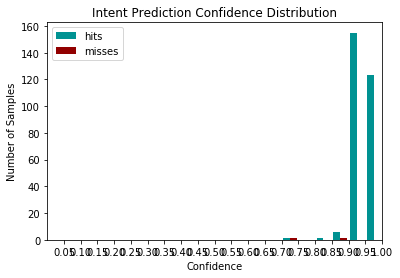

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9988190329968334
INFO:rasa_nlu.evaluate:Precision: 0.9988641239422376
INFO:rasa_nlu.evaluate:Accuracy:  0.9988623435722411
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

         bff       1.00      1.00      1.00        17
       color       1.00      1.00      1.00        13
        food       1.00      1.00      1.00        17
       genre       1.00      1.00      1.00        15
       hobby       1.00      1.00      1.00        11
         how       1.00      1.00      1.00        24
        joke       1.00      1.00      1.00         7
   languages       1.00      1.00      1.00        14
     license       1.00      1.00      1.00        14
        live       1.00      1.00      1.00        13
          me       1.00      0.86      0.92         7
       movie       1.00      1

In [4]:
from rasa_nlu.evaluate import run_evaluation
run_evaluation('../../bot/data/intents/', model_directory)

### Lista de Problemas

O arquivo `erros,json` mostra os erros encontrados após executar o comando `rasa_nlu.evaluate.run_evaluation`.

Normalmente os erros mostrados são textos repetidos nos exemplos de diferrentes `intents`.

Caso o arquivo não seja gerado significa que não foram encontrados erros.

In [5]:
%cat errors.json

{
    "intent_errors": [
        {
            "text": "e o c#",
            "intent": "languages",
            "intent_prediction": {
                "name": "",
                "confidence": 0.0
            }
        },
        {
            "text": "tudo bom",
            "intent": "cumprimentar",
            "intent_prediction": {
                "name": "tudo_bem",
                "confidence": 0.8885884284973145
            }
        },
        {
            "text": "como vai",
            "intent": "tudo_bem",
            "intent_prediction": {
                "name": "cumprimentar",
                "confidence": 0.7437047362327576
            }
        }
    ]
}

### Avaliação do modelo de NLU treinado

Caso queira testar mensagens específicas mande a mensagem na célula seguinte:

In [6]:
pprint(interpreter.parse('O que é um bot?'))

{
  "intent": {
    "name": "food",
    "confidence": 0.6073800921440125
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "food",
      "confidence": 0.6073800921440125
    },
    {
      "name": "movie",
      "confidence": 0.48714256286621094
    },
    {
      "name": "languages",
      "confidence": 0.3399764597415924
    },
    {
      "name": "despedir",
      "confidence": 0.2153129130601883
    },
    {
      "name": "bff",
      "confidence": 0.21298497915267944
    },
    {
      "name": "playlist",
      "confidence": 0.21115748584270477
    },
    {
      "name": "towel",
      "confidence": 0.1584913432598114
    },
    {
      "name": "license",
      "confidence": 0.12505900859832764
    },
    {
      "name": "hobby",
      "confidence": 0.10494726896286011
    },
    {
      "name": "genre",
      "confidence": 0.0806046798825264
    }
  ],
  "text": "O que \u00e9 um bot?"
}
